<a href="https://colab.research.google.com/github/gundaminpde/2023_F_ML_lecture/blob/main/REINFORCE_1st.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gym ## ==0.17.3
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 10 not upgraded.
Need to get 7,814 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1

In [2]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [3]:
from IPython import display as ipythondisplay

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:

import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

import gym




/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


1/1 [==============================] - 0s 17ms/step


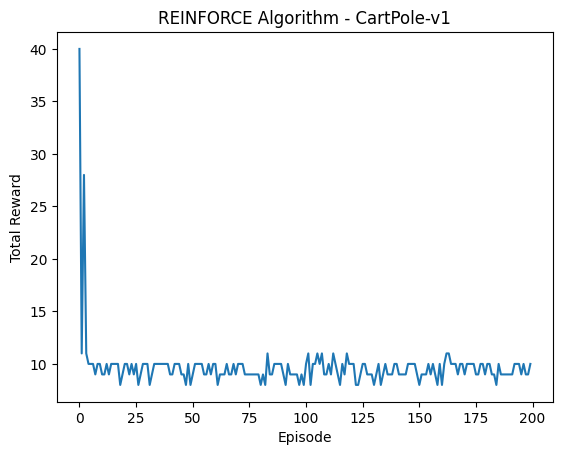

In [5]:

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Define the REINFORCE function
def reinforce(env, num_episodes=50, learning_rate=0.01, gamma=0.99): ## 원래는 1000
    # Get the number of actions and observations from the environment

    # 아래 env = gym.make('CartPole-v1')로 가지고 왔어요.

    num_actions = env.action_space.n                   # action의 갯수
    num_observations = env.observation_space.shape[0]  # state의 갯수

    # Create a simple neural network as the policy function
    # 아래 model이 바로 pi(a|s)입니다.

    model = Sequential()
    model.add(Dense(32, input_shape=(num_observations,), activation='relu'))
    model.add(Dense(num_actions, activation='softmax'))
    # Policy pi(a|s)가 action의 갯수를 차원으로 가진 softmax로 표현된다.

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate)) # 이 부분이 신묘해요.
    # G_t를 target으로 하여 G_t log pi(a|s)를 만들기 위해 crossentropy를 사용한다.



    episode_rewards = []

    for episode in range(num_episodes):
        observation = env.reset() # 새로운 에피소드를 시작 이제 S_0
        done = False
        episode_reward = 0

        # Lists to store the trajectory data
        observations = []         # State S_t 순서대로 모으기
        actions = []              # A_t 순서대로 모으기
        rewards = []              # R_{t+1} 순서대로 모으기

        while not done: # 이제 새 에피소드를 시작합니다.
            # Get the action probabilities based on the current observation and policy
            # 아래는 아래 model이 pi(a|s)이며 observation 즉 state S_t를 넣으면 A_t의 확률을 만든다. 아래의 action 부분과 합쳐져서 A_t를 결정한다.
            action_probabilities = model.predict(np.expand_dims(observation, axis=0)).flatten()

            # Check for NaN values in action probabilities
            # 패스
            if np.isnan(action_probabilities).any():
                break

            # Sample an action from the action probabilities
            # 위의 action_probabilities의 pi(a|S_t)를 만족하는 샘플링으로 A_t를 다음과 같이 결정한다.
            action = np.random.choice(range(num_actions), p=action_probabilities)

            # Take a step in the environment with the chosen action
            # 방금 A_t을 시행해보고 다음 단계에서 S_{t+1}, R_{t+1}, 끝났나?를 받습니다.
            new_observation, reward, done, _ = env.step(action)


            # Store the trajectory data
            # 새롭게 받은 S_{t}, A_{t}, R_{t+1}을 각각 추가하여 굴비처럼 엮어서 기록한다.
            observations.append(observation)
            actions.append(action)
            rewards.append(reward)


            #한개의 episode 전체 return G_0를 구하기 위해 적어 놓습니다.
            episode_reward += reward
            # 다음 A_{t+1}을 위해 S_{t+1}을 observation으로 설정합니다.
            observation = new_observation
            #이제 루프 while not done:를 돌며 에피소드 한개를 완성한다.


        if not np.isnan(action_probabilities).any():
            # Convert lists to numpy arrays for easier manipulation
            # 에피소드 S_{t+1}, A_{t}, R_{t+1}을 계속 추가하여 만든 굴비 줄을 이제 numpy array로 바꾼다.
            observations = np.array(observations)
            actions = np.array(actions)
            rewards = np.array(rewards)
            # 또 다시 에피소드가 시작되면 list []으로 초기화한다.


            # Calculate the return (discounted cumulative rewards) for each time step
            returns = np.zeros_like(rewards) ## rewards와 같은 형식으로 빵으로 채워주세요.
            G = 0
            for t in reversed(range(len(rewards))):
                G = rewards[t] + gamma * G
                returns[t] = G
            # 위의 과정은 G_T = rewards[T], G_{T-1}= rewards[T-1] + gamma * rewards[T],
            # G_{T-2} = rewards[T-2] + gamma * G_{t-1}, ...이다.
            # 여기서 G_t = returns[t]이다.


            # Compute the policy gradient update
            for t in range(len(rewards)):
                state = observations[t] # S_t
                action = actions[t] # A_t
                discounted_return = returns[t] # G_t

                # Compute the action probabilities for the current state
                # 아래는 pi(a|S_t)를 구하는 것이다. 위에서 while not done: 이라는 에피소드를 진행하며 시행했지만,
                # 어디 적어두지 않아서 다시 한 것이다.
                ### 아래 action_probabilities는 제거해도 상관없어서 제거하였음.
                ### action_probabilities = model.predict(np.expand_dims(state, axis=0)).flatten()

                # 우리는 정확히 pi(A_t|S_t)가 필요하다. 그 부분만 뽑아내기 위해 다음과 같이 A_t 인 부분만 1, 나머지 0
                # 그리고 확률과 내적하면 pi(A_t|S_t)만 나타난다.
                # Create a one-hot vector for the chosen action
                target = np.zeros(num_actions)
                target[action] = 1



                # Update the policy weights using policy gradient update
                # 가지고 싶은 것은 G_t * log pi (A_t| S_t)이다.
                # discounted_return * target 통해 G_t 곱하기 A_t 번째만 1인 원핫인코드된 벡터를 가진다.
                # 여기에 S_t를 모델어 넣어 pi (a |S_t)를 결과로 넣고 cross-entropy error로 오차를 계산하면,
                # 딱 - G_t * log pi (A_t| S_t)이고 이것으로 gradient descent를 하면 -없는 G_t * log pi (A_t| S_t)를 ascent하는 것이다.
                model.train_on_batch(np.expand_dims(state, axis=0), np.expand_dims(discounted_return * target, axis=0))

            episode_rewards.append(episode_reward)

    return episode_rewards


# Main code to run REINFORCE and visualize rewards
if __name__ == "__main__":
    env = gym.make('CartPole-v1')

    # Set random seed for reproducibility (optional)
    np.random.seed(42)

    # Run REINFORCE algorithm
    episode_rewards = reinforce(env, num_episodes=200, learning_rate=0.01, gamma=0.99) ## 원래는 num_episodes = 1000, 정성이 부족한지 해 보아도 잘 향상이 안된다.

    # Visualize rewards
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('REINFORCE Algorithm - CartPole-v1')
    plt.show()